In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# -- 1) EXACT SOLUTION FOR THE OSCILLATOR --
def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    # Check underdamped condition
    if mu**2 >= 4 * m * k:
        raise ValueError("The system is not underdamped. Ensure μ^2 < 4 * m * k.")
    
    omega = np.sqrt(k/m - (mu/(2*m))**2)
    
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2*m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    return y_exact


# -- 2) PDF FUNCTIONS FOR p(x) AND g(x) --
def p_pdf(m, mu):
    """ PDF of the ORIGINAL distribution (product of independent normals).
        m ~ N(1, 0.1^2), mu ~ N(0.6, 0.05^2), k ~ N(5, 0.2^2), y0 ~ N(-0.4, 0^2)
    """
    pm = norm.pdf(m, loc=1.0, scale=0.1)
    pmu = norm.pdf(mu, loc=0.6, scale=0.05)
    return pm * pmu 


gm_mean = 1.0
gmu_mean = 0.6
gm_std=0.1
gmu_std=0.05
k_exact = 5.0
y0_exact = -0.4
v0_exact = 3.0

def g_pdf(m, mu):
    """ PDF of the PROPOSAL distribution g(x).
        Adjust means or std to focus on "dangerous" region, e.g. larger mass or smaller damping
    """
    # Example: shift mass to a higher mean (like 1.3) and damping to a smaller mean (like 0.45)
    gm = norm.pdf(m, loc=gm_mean, scale=gm_std)
    gmu = norm.pdf(mu, loc=gmu_mean, scale=gm_std)

    return gm * gmu 

def sample_from_g(N):
    """ Draw N samples from the proposal distribution g(x). """
    m_samples = np.random.normal(loc=gm_mean, scale=gm_std, size=N)
    mu_samples = np.random.normal(loc=gmu_mean, scale=gmu_std, size=N)
    return m_samples, mu_samples


# -- 3) IMPORTANCE SAMPLING --
def IS_sim(N, t, threshold=-1.0):
    """
    Estimate probability that oscillator crosses below 'threshold'
    at ANY time in [t.min(), t.max()] using importance sampling.
    """
    # 1) Sample from g(x)
    m_samples, mu_samples = sample_from_g(N)

    # 2) Evaluate weights w_i = p(x_i) / g(x_i)
    w = []
    indicators = []
    for i in range(N):
        # Evaluate ratio
        px = p_pdf(m_samples[i], mu_samples[i] )
        gx = g_pdf(m_samples[i], mu_samples[i])
        w.append(px / gx if gx > 1e-30 else 0.0)

    # 3) Evaluate failure: does y(t) < threshold at ANY time?
        y = damped_harmonic_oscillator(t, m_samples[i], mu_samples[i],
                                       k_exact, y0_exact, v0_exact)
        # if any point is below threshold, it's a 'failure'
        fail = np.any(y < threshold)
        indicators.append(fail)

    w = np.array(w)
    indicators = np.array(indicators, dtype=float)

    # 4) Weighted average for probability
    # p_fail = (1/N) * sum( I{fail} * w_i )
    p_fail = np.mean(indicators * w)

    return p_fail,w

# 4) Run and compare with standard MC
if __name__ == "__main__":
    # np.random.seed(0)
    t = np.linspace(2, 3, 50)
    N = 10000

    # Importance sampling approach
    p_fail_is = IS_sim(N, t, threshold=-0.7)

    print(f"Importance sampling estimate: {p_fail_is}")


Importance sampling estimate: (0.7187056191837916, array([1.93185992, 0.66804953, 1.89890394, ..., 1.97572532, 1.58675753,
       1.85822577]))


In [43]:
print(f"Mean weight: {np.mean(p_fail_is[1]):.3f}, Std of weights: {np.std(p_fail_is[1]):.3f}")


Mean weight: 1.515, Std of weights: 0.490


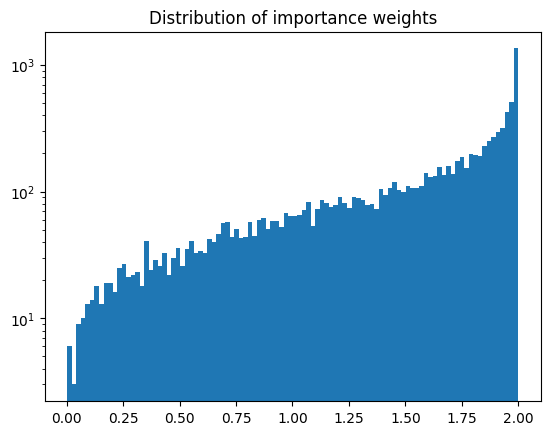

In [42]:
plt.hist(p_fail_is[1], bins=100)
plt.title("Distribution of importance weights")
plt.yscale('log')
plt.show()


In [45]:
def MC_sim(Num,m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):

    # Uncertainty in input parameters
    m_samples = np.random.normal(m, 0.1, Num)
    mu_samples = np.random.normal(mu, 0.05, Num)
    k_samples = np.random.normal(k, 0.0, Num)
    y0_samples = np.random.normal(y0, 0.0, Num)

    # Monte Carlo simulation for the damped harmonic oscillator
    y_mc = []
    for i in range(Num):
        y_mc.append(damped_harmonic_oscillator(t, m_samples[i], mu_samples[i], k_samples[i], y0_samples[i], v0))
    
    return y_mc, m_samples, mu_samples, k_samples, y0_samples

def plot_MC(y_mc):
    y_exact=damped_harmonic_oscillator(t)

    # probability distribution of the displacement at each time step
    y_mc = np.array(y_mc)
    y_mean = np.mean(y_mc, axis=0)
    y_std = np.std(y_mc, axis=0)

    #plotting the mean and standard deviation of the Monte Carlo simulation
    plt.figure(figsize=(10, 6))
    plt.plot(t, y_exact, label='Exact Solution', color='red')
    plt.plot(t, y_mean, label='Mean', color='blue')
    # 3 Standard Deviations
    plt.fill_between(t, y_mean - 3 * y_std, y_mean + 3 * y_std, color='blue', alpha=0.1, label='3 Standard Deviations')
    # 2 Standard Deviations
    plt.fill_between(t, y_mean - 2 * y_std, y_mean + 2 * y_std, color='blue', alpha=0.2, label='2 Standard Deviations')
    # 1 Standard Deviation
    plt.fill_between(t, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.3, label='1 Standard Deviation')
    plt.title('Monte Carlo Simulation of Damped Harmonic Oscillator')
    plt.xlabel('Time (t)')
    plt.ylabel('Displacement (y)')
    plt.grid(True)
    plt.legend()
    plt.show()

def treshold_MC(y_mc, y_threshold=-1.0):
    y_threshold= np.array(y_threshold)
    # Estimate the probability of exceeding the threshold using Importance Sampling
    prob_exceed = np.mean(np.any(y_mc < y_threshold, axis=1))
    print(f"Estimated Probability of Exceeding Threshold: {prob_exceed}")

    return prob_exceed

Num = 20000000
t = np.linspace(2.2, 2.8, 30)
y_mc, m_samples, mu_samples, k_samples, y0_samples = MC_sim(Num,m=1.0)
treshold_MC(y_mc, y_threshold=-1.0)
# plot_MC(y_mc)


Estimated Probability of Exceeding Threshold: 1.33e-05


1.33e-05

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Exact solution for the damped oscillator
def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    if mu**2 >= 4 * m * k:
        raise ValueError("The system is not underdamped. Ensure μ^2 < 4*m*k.")
    omega = np.sqrt(k/m - (mu/(2*m))**2)
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2*m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    return y_exact

# Original target distribution p(x)
def p_pdf(m, mu, k, y0):
    pm = norm.pdf(m, loc=1.0, scale=0.1)
    pmu = norm.pdf(mu, loc=0.6, scale=0.05)
    pk = norm.pdf(k, loc=5.0, scale=0.2)
    py0 = 1.0  # y0 is fixed at -0.4
    return pm * pmu * pk * py0

# Initial proposal distribution g(x)
def sample_from_g_initial(N):
    # Choose a broad distribution to cover a wide range
    m_samples = np.random.normal(loc=1.2, scale=0.2, size=N)
    mu_samples = np.random.normal(loc=0.5, scale=0.05, size=N)
    k_samples = np.random.normal(loc=5.0, scale=0.3, size=N)
    y0_samples = np.full(N, -0.4)
    return m_samples, mu_samples, k_samples, y0_samples

def g_pdf_initial(m, mu, k, y0):
    gm = norm.pdf(m, loc=1.2, scale=0.2)
    gmu = norm.pdf(mu, loc=0.5, scale=0.05)
    gk = norm.pdf(k, loc=5.0, scale=0.3)
    gy0 = 1.0
    return gm * gmu * gk * gy0

# Adaptive Importance Sampling
def adaptive_IS_sim(N, t, threshold=-1.0):
    # ------ Round 1: Initial Proposal ------
    m_samples, mu_samples, k_samples, y0_samples = sample_from_g_initial(N)
    weights_round1 = []
    indicators_round1 = []
    
    for i in range(N):
        px = p_pdf(m_samples[i], mu_samples[i], k_samples[i], y0_samples[i])
        gx = g_pdf_initial(m_samples[i], mu_samples[i], k_samples[i], y0_samples[i])
        weight = px / gx if gx > 1e-30 else 0.0
        weights_round1.append(weight)
        y = damped_harmonic_oscillator(t, m_samples[i], mu_samples[i], k_samples[i], y0_samples[i], v0=3.0)
        fail = np.any(y < threshold)
        indicators_round1.append(fail)
    
    weights_round1 = np.array(weights_round1)
    indicators_round1 = np.array(indicators_round1, dtype=float)
    p_fail_round1 = np.mean(indicators_round1 * weights_round1)
    print("Round 1 IS estimate:", p_fail_round1)
    
    # Identify failure samples from round 1
    failure_indices = np.where(indicators_round1 == 1)[0]
    print("Number of failure samples in Round 1:", len(failure_indices))
    if len(failure_indices) == 0:
        print("No failures in Round 1; cannot adapt proposal.")
        return p_fail_round1
    
    # ------ Fit Adaptive Proposal based on failure samples ------
    m_fail = m_samples[failure_indices]
    mu_fail = mu_samples[failure_indices]
    k_fail = k_samples[failure_indices]
    
    # Compute the mean and std for failure samples
    m_mean, m_std = np.mean(m_fail), np.std(m_fail)
    mu_mean, mu_std = np.mean(mu_fail), np.std(mu_fail)
    k_mean, k_std = np.mean(k_fail), np.std(k_fail)
    
    print("Adaptive proposal parameters:")
    print("m: mean =", m_mean, ", std =", m_std)
    print("mu: mean =", mu_mean, ", std =", mu_std)
    print("k: mean =", k_mean, ", std =", k_std)
    
    # Define adaptive proposal sampling functions using the fitted parameters
    def sample_from_g_adaptive(N):
        m_samples = np.random.normal(loc=m_mean, scale=m_std, size=N)
        mu_samples = np.random.normal(loc=mu_mean, scale=mu_std, size=N)
        k_samples = np.random.normal(loc=k_mean, scale=k_std, size=N)
        y0_samples = np.full(N, -0.4)
        return m_samples, mu_samples, k_samples, y0_samples
    
    def g_pdf_adaptive(m, mu, k, y0):
        gm = norm.pdf(m, loc=m_mean, scale=m_std)
        gmu = norm.pdf(mu, loc=mu_mean, scale=mu_std)
        gk = norm.pdf(k, loc=k_mean, scale=k_std)
        gy0 = 1.0
        return gm * gmu * gk * gy0
    
    # ------ Round 2: Adaptive Proposal ------
    m_samples2, mu_samples2, k_samples2, y0_samples2 = sample_from_g_adaptive(N)
    weights_round2 = []
    indicators_round2 = []
    
    for i in range(N):
        px = p_pdf(m_samples2[i], mu_samples2[i], k_samples2[i], y0_samples2[i])
        gx = g_pdf_adaptive(m_samples2[i], mu_samples2[i], k_samples2[i], y0_samples2[i])
        weight = px / gx if gx > 1e-30 else 0.0
        weights_round2.append(weight)
        y = damped_harmonic_oscillator(t, m_samples2[i], mu_samples2[i], k_samples2[i], y0_samples2[i], v0=3.0)
        fail = np.any(y < threshold)
        indicators_round2.append(fail)
    
    weights_round2 = np.array(weights_round2)
    indicators_round2 = np.array(indicators_round2, dtype=float)
    p_fail_round2 = np.mean(indicators_round2 * weights_round2)
    print("Round 2 (adaptive) IS estimate:", p_fail_round2)
    
    return p_fail_round2

# Run the adaptive IS simulation
if __name__ == "__main__":
    #np.random.seed(0)
    t = np.linspace(0, 5, 100)
    N = 10000
    p_fail_adaptive = adaptive_IS_sim(N, t, threshold=-0.696)
    print("Final adaptive IS probability estimate:", p_fail_adaptive)


Round 1 IS estimate: 0.48752173893245365
Number of failure samples in Round 1: 9485
Adaptive proposal parameters:
m: mean = 1.2225648380666951 , std = 0.1787489353499321
mu: mean = 0.4980809618405072 , std = 0.049974190514808
k: mean = 4.997952415664895 , std = 0.2994074464119004
Round 2 (adaptive) IS estimate: 0.4667789632012057
Final adaptive IS probability estimate: 0.4667789632012057
